In [38]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from collections import namedtuple
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm.auto import tqdm
import re
import numdifftools.nd_algopy as nda
from scipy.special import ellipk, ellipe
from natural_units import fr, to
from graphing import standard, square, double_square, large_standard, plot, linear_fit
from simulation import m, c, e, gamma_p, gamma_u, partial_scalar, contract, simulate, save_solution, load_solution

In [2]:
def coil(B0, a, pos):
    r = np.linalg.norm(pos[1:2])
    x = np.abs(pos[0])
    if r == 0:
        if x == 0:
            return B_0
        return B_0 * a**3 / (x**2 + a**2)**1.5
    alpha = r/a
    beta = x/a
    gamma = x/r
    Q = (1 + alpha)**2 + beta**2
    k = np.sqrt(4 * alpha / Q)
    K = ellipk(k**2)
    E = ellipe(k**2)
    Bx = np.linalg.norm(B_0) / (np.pi * np.sqrt(Q)) * (E * (1 - alpha**2 - beta**2)/(Q - 4*alpha) + K)
    Br = np.linalg.norm(B_0) * gamma / (np.pi * np.sqrt(Q)) * (E * (1 + alpha**2 + beta**2)/(Q - 4*alpha) - K)
    return Bx * np.array([1, 0, 0]) + Br * np.array([0, pos[1], pos[2]])/r
def G(a, b, theta):
    cs = np.cos(theta)
    sn = np.sin(theta)
    g = 1 - a * cs
    top = 4*g**2 * ((1+a**2) * (1+cs**2) - 4*a*cs) - (1 - a**2 + 3 * b**2) * b**2 * sn**4
    bottom = 4 * (g**2 - (b**2) * (sn**2))**3.5
    F = top/bottom
    return 3/4 * (1 - (a**2 + b**2))**2 * F


In [52]:
E_0 = fr("V/m", np.array([0, 0, 0]))
E_x = lambda x: E_0
B_0 = fr("T", np.array([10, 0, 0]))
B_x = lambda x: B_0
tau_span = (0, fr("us", 0.01))
p0 = fr("MeV", np.array([0, 100, 100, 0])/np.sqrt(2))
p0[0] = gamma_p(p0)*m
u0 = p0/m
x0 = fr("m", np.array([0, 0, 0, 0]))
u_atol = fr("m/s", 10000)
x_atol = fr("m", 0.01)
atol = np.array([u_atol, u_atol, u_atol, u_atol, x_atol, x_atol, x_atol, x_atol])
rtol = 1e-5
time_unit = "us"

In [4]:
fun, solution = simulate(tau_span, u0, x0, E_x, B_x, rtol=rtol, atol=atol)

  0%|          | 0/10.0ps [00:00<?, ?ps/s]

In [5]:
save_solution("solution.pkl", solution)

In [6]:
solution = load_solution("solution.pkl")

In [7]:
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 335930
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001C3B5018520>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.51941939e+03, 3.03883878e+03, ...,
       1.51896356e+07, 1.51911551e+07, 1.51926745e+07])
 t_events: None
        y: array([[ 1.95697631e+02,  1.95696718e+02,  1.95695805e+02, ...,
         1.87488071e+02,  1.87487334e+02,  1.87486596e+02],
       [ 1.38377315e+02,  1.38376670e+02,  1.38376024e+02, ...,
         1.32572356e+02,  1.32571834e+02,  1.32571313e+02],
       [ 1.38377315e+02, -2.58895021e+01, -1.28687751e+02, ...,
        -4.40051011e+01,  1.25355670e+02, -2.90163874e+00],
       ...,
       [ 0.00000000e+00,  2.10252686e+05,  4.20504391e+05, ...,
         2.05624892e+09,  2.05645035e+09,  2.05665179e+09],
       [ 0.00000000e+00,  1.17419162e+05, -4.39354952e+04, ...,
        -1.02989513e+05, -1.80712558e

In [22]:
y = solution.y
u, x = np.split(y, 2)
tau = solution.t

In [23]:
dydtau = np.vectorize(fun, signature="(),(8)->(8)")(tau, y.T)

In [24]:
dudtau, dxdtau = np.split(dydtau, 2)

In [25]:
a = dudtau

In [26]:
t = x[0]/c
p = u[1:]*m
r = x[1:]

In [27]:
v = u[1:] / gamma_p(u*m, axis=0)
r_corr = r - np.tile(np.mean(r, axis=1), (r.shape[1],1)).T
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:], axis=0)**2
beta_perp = np.linalg.norm(v_corr[1:], axis=0)/c
beta = np.linalg.norm(v_corr, axis=0)/c
power = 2*(e*omega[0])**2/(3*c)*(beta_perp**2)/(1 - beta**2)
frequency = 2 * np.pi * np.abs(omega[0])
period = 1/frequency
B = np.vectorize(B_x, signature="(4)->(3)")(x.T).T
E = np.vectorize(E_x, signature="(4)->(3)")(x.T).T
beta = v/c
bll = (np.sum(beta*B, 0)/np.linalg.norm(B, axis=0))
bperp = np.sqrt(np.linalg.norm(beta, axis=0)**2 - bll**2)

In [28]:
obs_r = lambda tau: fr("m", np.array([c*tau, 0, 0, 0]))

In [29]:
def contravariant_field_generated(tau_0):
    y = solution.sol(tau_0)
    u, x = np.split(y, 2)
    r = obs_r(tau_0)
    dydtau = fun(tau_0, y)
    dudtau, dxdtau = np.split(dydtau, 2)
    a = dudtau
    xminr = x - r
    lowered_xminr = contract(xminr)
    xminrdotu = np.einsum("l,l", lowered_xminr, u)
    if xminrdotu == 0:
        return np.zeros((4,4))
    xminrdota = np.einsum("l,l", lowered_xminr, a)
    xminrouta = np.einsum("a,b", xminr, a)
    xminroutv = np.einsum("a,b", xminr, u)
    return e/xminrdotu**3 * (xminrdotu * (xminrouta - xminrouta.T) - (c**2 + xminrdota) *  (xminroutv - xminroutv.T))

In [84]:
obs = np.vectorize(r_r, signature="()->(4)")(tau).T
tau_0 = tau - np.linalg.norm(x - obs, axis=0)/c
F_generated = np.vectorize(contravariant_field_generated, signature="()->(4,4)")(tau_0)

In [85]:
def contravariant_stress_energy(contravariant_F):
    mixed_F = contract(contravariant_F)
    covariant_F = contract(mixed_F)
    return np.einsum("ua,va->uv", contravariant_F, mixed_F) - 1/4 * contract(np.eye(4)) * np.einsum("ab,ab", covariant_F, contravariant_F)

In [87]:
T_generated = np.vectorize(contravariant_stress_energy, signature="(4,4)->(4,4)")(F_generated)

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

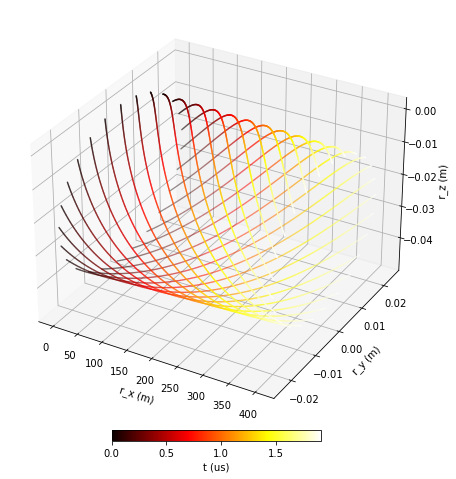

In [62]:
plot(r, "r", "m", t, "t", time_unit, plt.figure(figsize=square), projection="3d")

<AxesSubplot:xlabel='t (us)', ylabel='E (MeV)'>

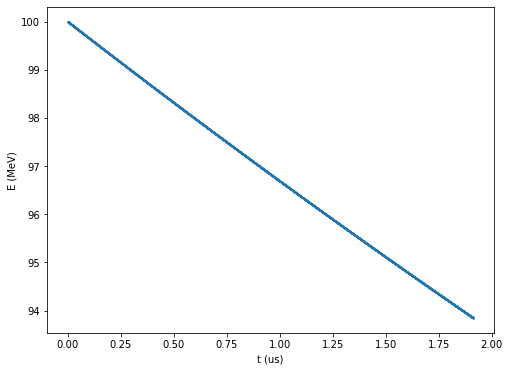

In [61]:
plot(np.sqrt(np.linalg.norm(p, axis=0)**2 + (m*c**2)**2), "E", "MeV", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='t (us)', ylabel='r (m)'>

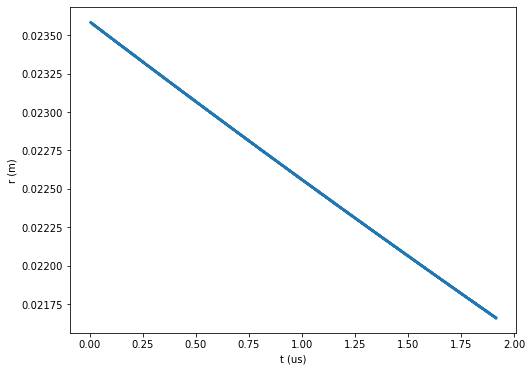

In [55]:
plot(np.linalg.norm(r_corr[1:], axis=0), "r", "m", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='t (us)', ylabel='v (m/s)'>

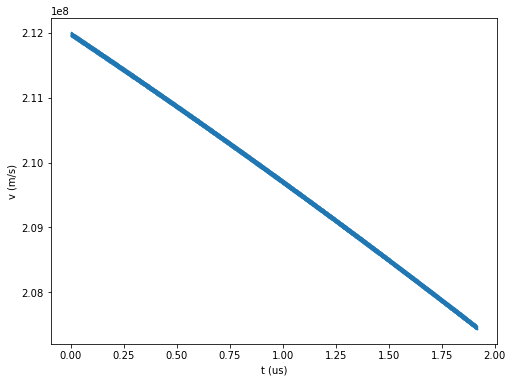

In [65]:
plot(np.linalg.norm(v_corr[1:], axis=0), "v", "m/s", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='t (us)', ylabel='f (GHz)'>

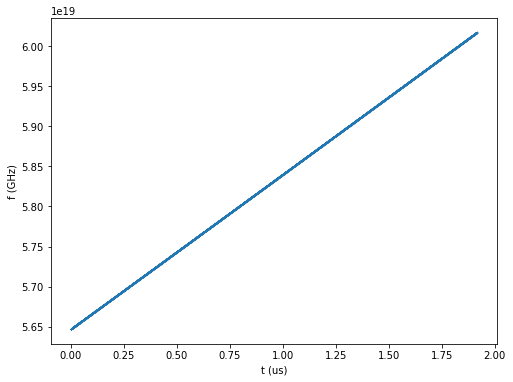

In [71]:
plot(frequency, "f", "GHz", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='t (us)', ylabel='T (ps)'>

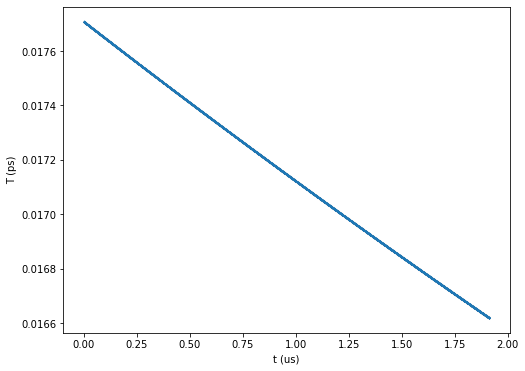

In [72]:
plot(period, "T", "ps", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

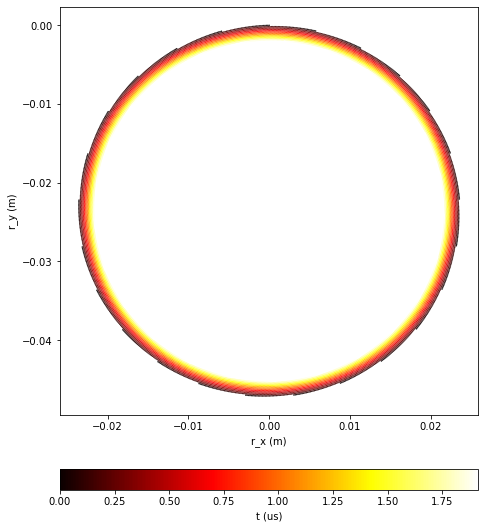

In [73]:
plot(r[1:], "r", "m", t, "t", time_unit, plt.figure(figsize=square))

<AxesSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

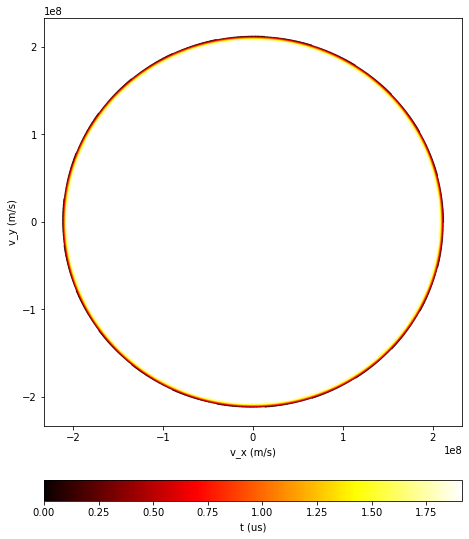

In [74]:
plot(v[1:], "v", "m/s", t, "t", time_unit, plt.figure(figsize=square))

<AxesSubplot:xlabel='t (us)', ylabel='P (W)'>

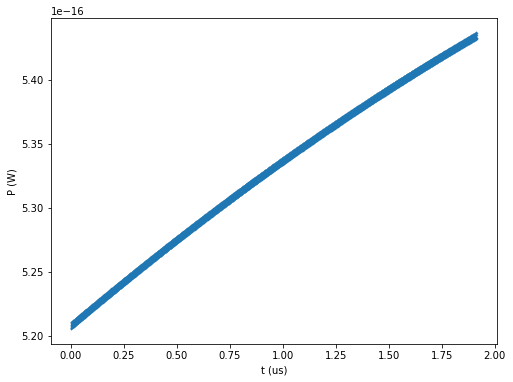

In [77]:
plot(power, "P", "W", t, "t", time_unit, plt.figure(figsize=standard))

In [ ]:
every_n = 200

In [ ]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
t_plot = t[::every_n]
p = np.linspace(0, 2*np.pi, 10000)
T, P = np.meshgrid(t[::every_n], p)
R = G(bll[::every_n], bperp[::every_n], P)
X, Y = R*np.cos(P), R*np.sin(P)
Z = T
ax.plot_surface(to("us",Z), X, Y, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("time (us) - x")
ax.set_ylabel("gain - radius")
ax.set_zlabel("$\\theta$ - angle")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
p = np.linspace(0, 2*np.pi, 10000)
T, P = np.meshgrid(t[1::every_n], p)
R = G(bll[1::every_n], bperp[1::every_n], P)*power[1::every_n]
X, Y = R*np.cos(P), R*np.sin(P)
Z = T
ax.plot_surface(to("us",Z), X, Y, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("time (us) - x")
ax.set_ylabel("power (W) - radius")
ax.set_zlabel("$\\theta$ - angle")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
b = np.linspace(0, 0.95, 100)
p = np.linspace(0, 2*np.pi, 100)
B, P = np.meshgrid(b, p)
R = G(0, B, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

In [ ]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for bperp in [0, 0.5, 0.8, 0.95]:
    ax.plot(theta, G(0, bperp, theta), label="$\\beta_{\perp} = " + str(bperp) + "$")
plt.legend()
ax.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
r = np.linspace(0, 1.5, 100)
p = np.linspace(0, 2*np.pi, 100)
ratio, P = np.meshgrid(r, p)
bperp = 0.9/np.sqrt(ratio**2 + 1)
bll = bperp*ratio
R = G(bll, bperp, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

In [ ]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for ratio in [0, 0.5, 1, 1.5]:
    bperp = 0.9/np.sqrt(ratio**2 + 1)
    bll = bperp*ratio
    ax.plot(theta, G(bll, bperp, theta), label="$\\beta_{\parallel} / \\beta_{\perp} = " + str(ratio) + "$")
plt.legend()
ax.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
r = np.linspace(1.5, 5, 100)
p = np.linspace(0, 2*np.pi, 100)
ratio, P = np.meshgrid(r, p)
bperp = 0.9/np.sqrt(ratio**2 + 1)
bll = bperp*ratio
R = G(bll, bperp, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

In [ ]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for ratio in [2, 5, 10]:
    bperp = 0.9/np.sqrt(ratio**2 + 1)
    bll = bperp*ratio
    ax.plot(theta, G(bll, bperp, theta), label="$\\beta_{\parallel} / \\beta_{\perp} = " + str(ratio) + "$")
plt.legend()
ax.grid(True)
plt.show()